In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from akita_utils.format_io import h5_to_df
from scipy import stats

In [2]:
# for all directories with results:
# python collect_jobs_and_clean.py /scratch2/smaruj/<directory> -g -l -n

In [3]:
stat_names = ["SCD", "SSD", "INS-16", "INS-64"]

In [6]:
data_dir = "/project/fudenber_735/akitaX1_analyses_data/genomic_disruption_experiment/disruption_by_permutation"

In [8]:
# reading h5 files to dataframes
df_m0 = h5_to_df(data_dir+"/model_0.h5", stat_names, average=False) 
df_m0_perm = h5_to_df(data_dir+"/model_0_perm.h5", stat_names, average=False)
df_m1 = h5_to_df(data_dir+"/model_1.h5", stat_names, average=False) 
df_m2 = h5_to_df(data_dir+"/model_2.h5", stat_names, average=False) 
df_m3 = h5_to_df(data_dir+"/model_3.h5", stat_names, average=False) 
df_m4 = h5_to_df(data_dir+"/model_4.h5", stat_names, average=False) 
df_m5 = h5_to_df(data_dir+"/model_5.h5", stat_names, average=False) 
df_m6 = h5_to_df(data_dir+"/model_6.h5", stat_names, average=False) 
df_m7 = h5_to_df(data_dir+"/model_7.h5", stat_names, average=False) 

In [9]:
def average_stat(df, model_index, head_index, stat="SCD"):
    if head_index == 1:
        target_indices = 6
    else:
        target_indices = 5
        
    df[f"{stat}_m{model_index}"] = df[[f"{stat}_h{head_index}_m{model_index}_t{target_index}" for target_index in range(target_indices)]].mean(axis=1)
    return df

In [10]:
df_m0 = average_stat(df_m0, model_index=0, head_index=1)
df_m0_perm = average_stat(df_m0_perm, model_index=0, head_index=1)
df_m1 = average_stat(df_m1, model_index=1, head_index=1)
df_m2 = average_stat(df_m2, model_index=2, head_index=1)
df_m3 = average_stat(df_m3, model_index=3, head_index=1)
df_m4 = average_stat(df_m4, model_index=4, head_index=1)
df_m5 = average_stat(df_m5, model_index=5, head_index=1)
df_m6 = average_stat(df_m6, model_index=6, head_index=1)
df_m7 = average_stat(df_m7, model_index=7, head_index=1)

In [11]:
SCD_collected = pd.concat([df_m0["SCD_m0"], df_m1["SCD_m1"], df_m2["SCD_m2"], df_m3["SCD_m3"], df_m4["SCD_m4"], df_m5["SCD_m5"], df_m6["SCD_m6"], df_m7["SCD_m7"]], axis=1)

## Disruption scores for specific sites are correlated across random motif permutations

Text(0, 0.5, 'aveSCD model 0, perm 2')

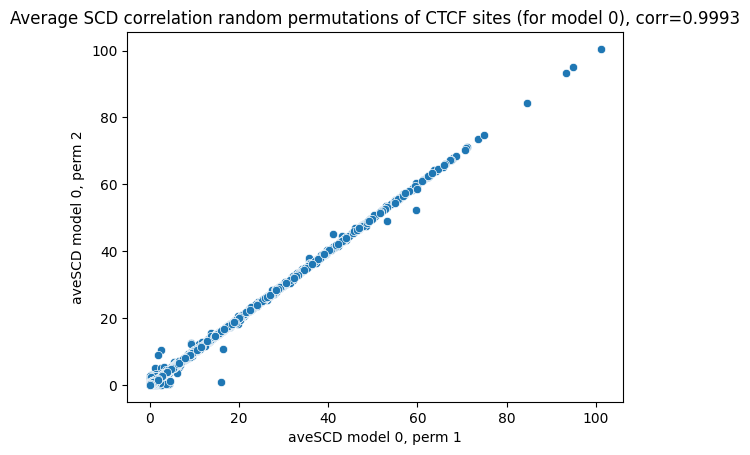

In [13]:
sn.scatterplot(x=df_m0["SCD_m0"], y=df_m0_perm["SCD_m0"])
perm_corr = round(stats.pearsonr(df_m0["SCD_m0"], df_m0_perm["SCD_m0"]).statistic, 4)
plt.title(f"Average SCD correlation random permutations of CTCF sites (for model 0), corr={perm_corr}")
plt.xlabel("aveSCD model 0, perm 1")
plt.ylabel("aveSCD model 0, perm 2")

## Correlations between models

Text(0, 0.5, 'aveSCD model 1')

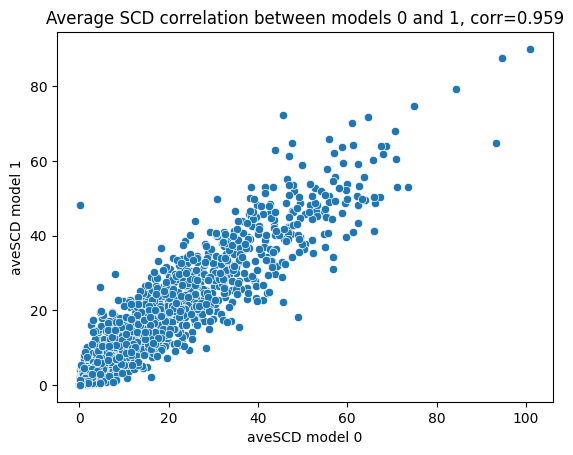

In [14]:
sn.scatterplot(x=df_m0["SCD_m0"], y=df_m1["SCD_m1"])
m0_m1_corr = round(stats.pearsonr(df_m0["SCD_m0"], df_m1["SCD_m1"]).statistic, 4)
plt.title(f"Average SCD correlation between models 0 and 1, corr={m0_m1_corr}")
plt.xlabel("aveSCD model 0")
plt.ylabel("aveSCD model 1")

## Correlations between all models

Text(0.5, 0.98, 'Correlations of SCD between models')

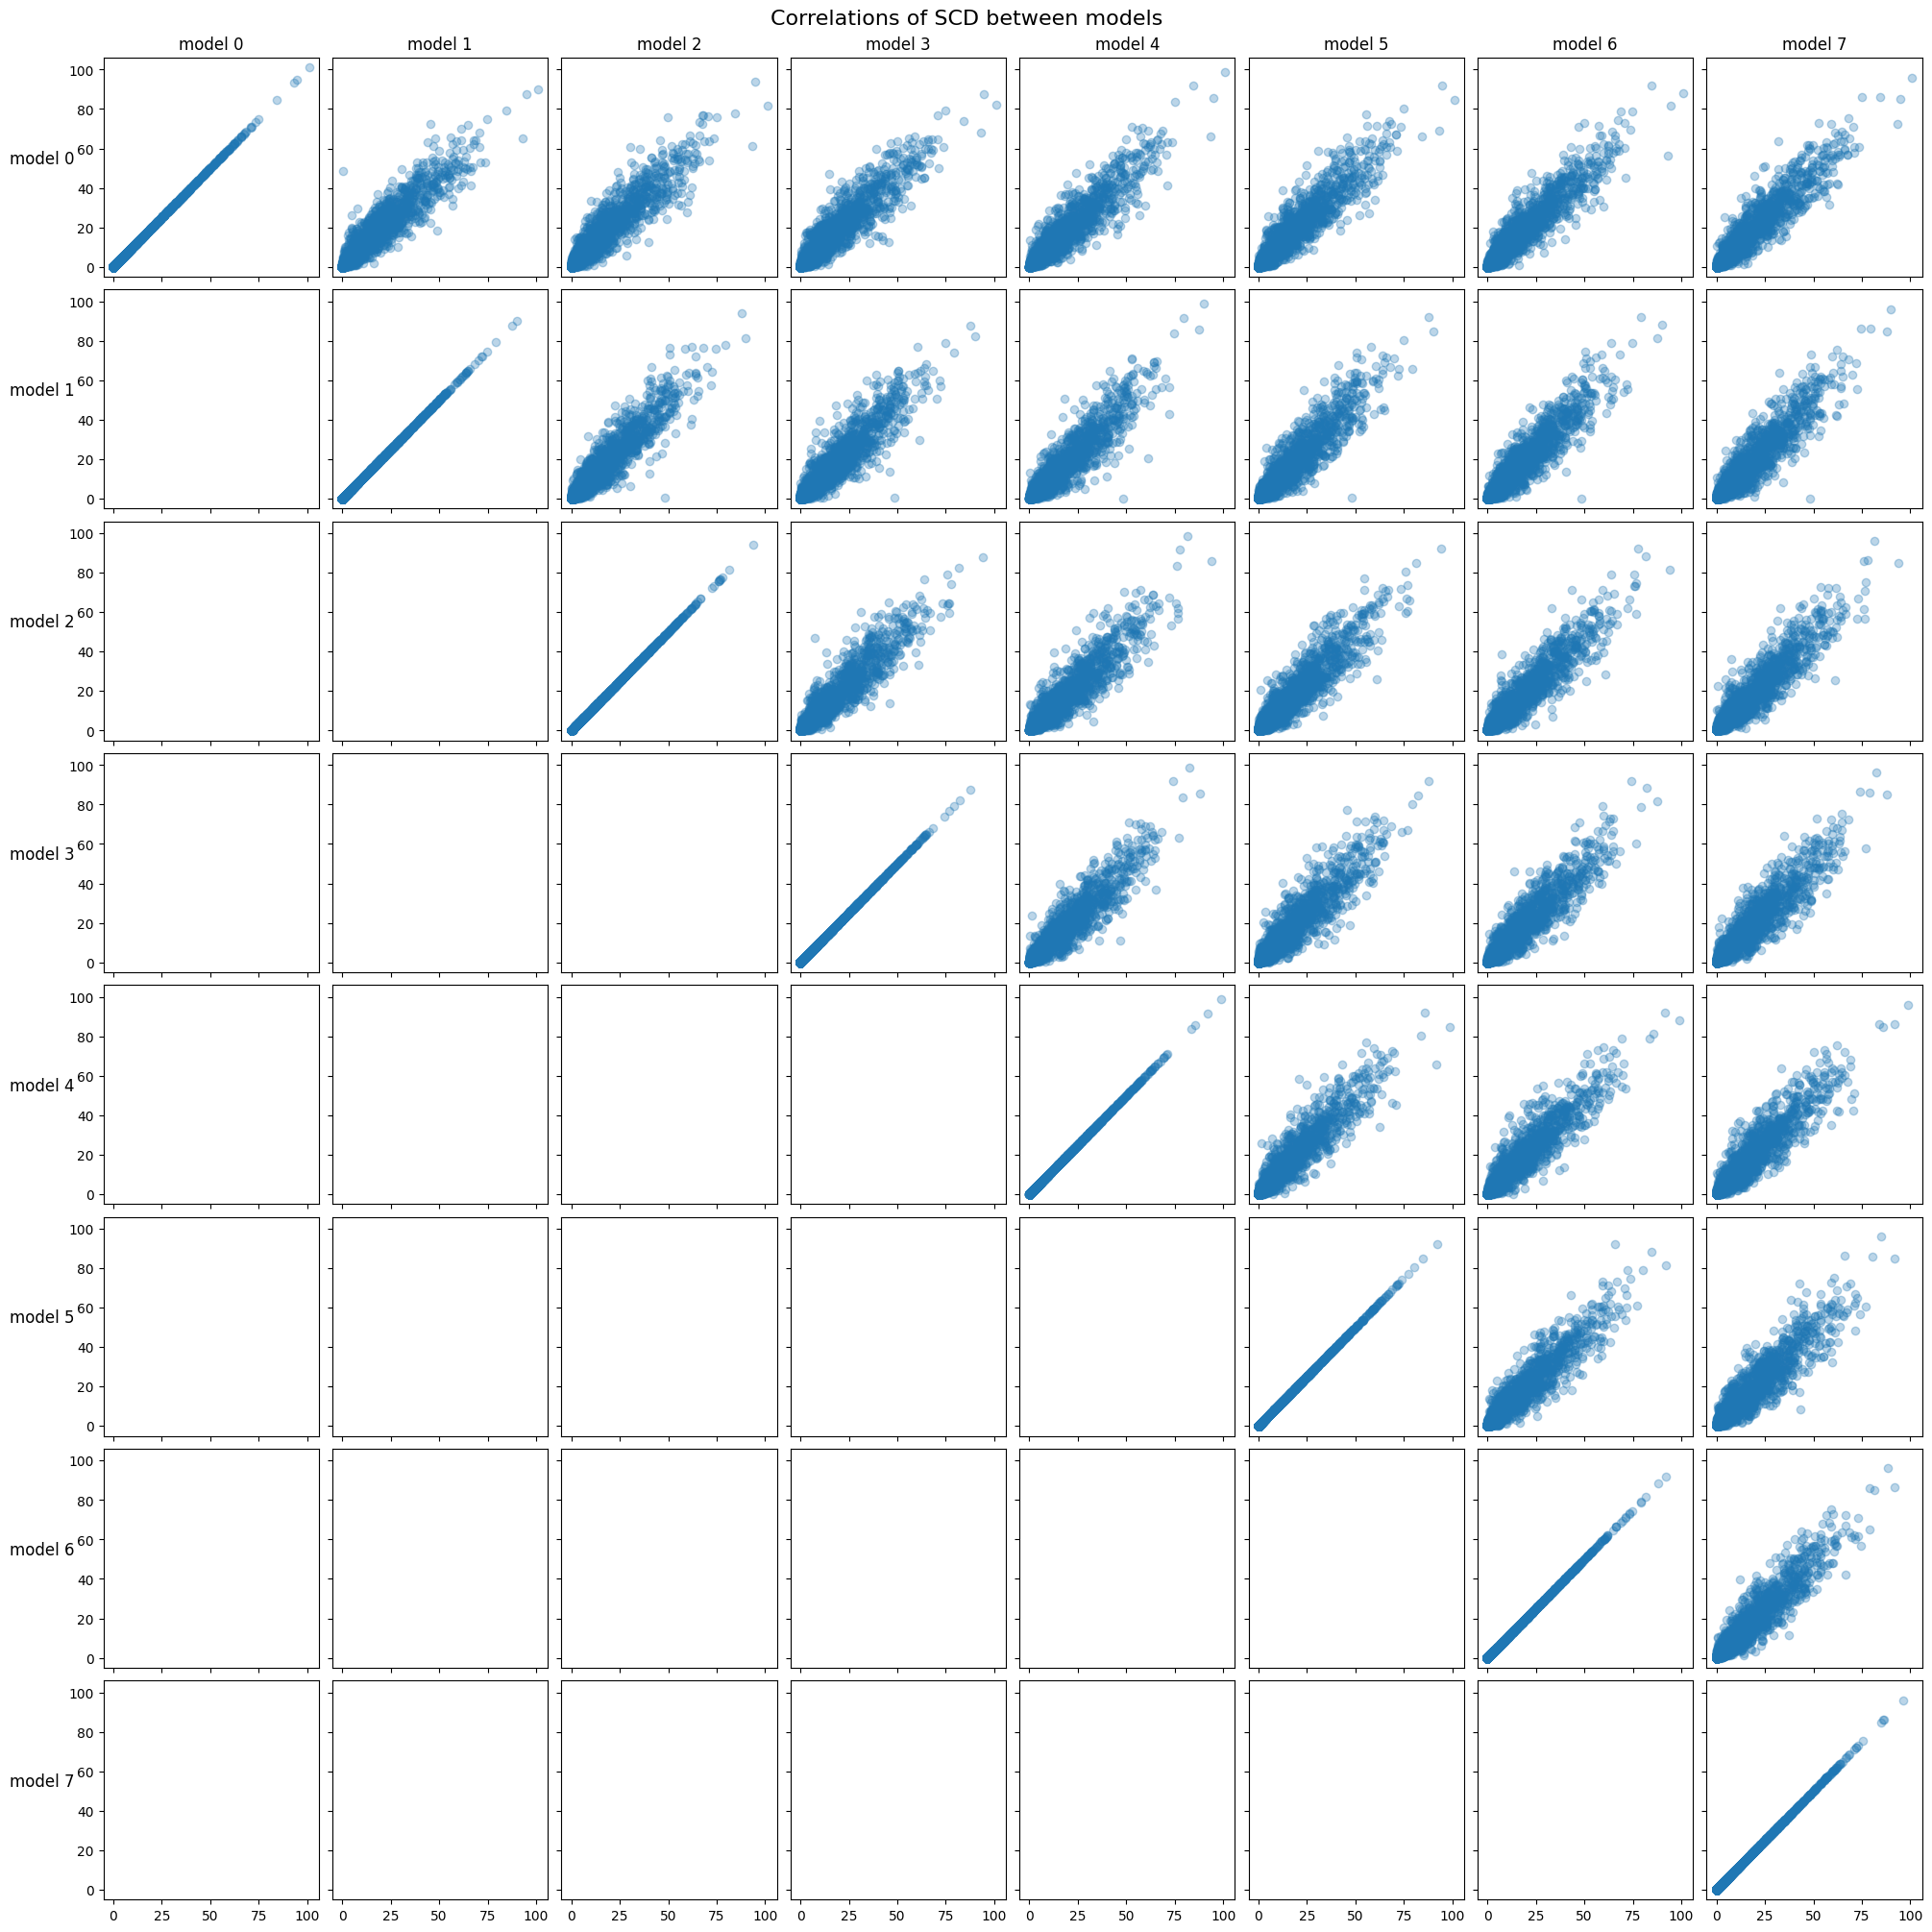

In [15]:
num_models = 8

SCD_corr_summary = np.zeros((num_models,num_models))

fig, axs = plt.subplots(num_models, num_models, figsize=(20, 20), sharex=True, sharey=True, layout="constrained")

for model_index_x in range(num_models):
    for model_index_y in range(num_models):
        if (model_index_y >= model_index_x):
            
            stat_x = np.array(SCD_collected[f"SCD_m{model_index_x}"])
            stat_y = np.array(SCD_collected[f"SCD_m{model_index_y}"])
            
            axs[model_index_x, model_index_y].scatter(x=stat_x, y=stat_y, alpha=0.3)
            
            SCD_corr_summary[model_index_x, model_index_y] = SCD_corr_summary[model_index_y, model_index_x] = stats.pearsonr(stat_x, stat_y).statistic
            
names = [f"model {i}" for i in range(num_models)]

for ax, col in zip(axs[0], names):
    ax.set_title(col, size=12)

for ax, row in zip(
    axs[:, 0],
    names,
):
    ax.set_ylabel(row, rotation=0, fontsize=12, labelpad=20)
    
fig.suptitle("Correlations of SCD between models", fontsize=16)

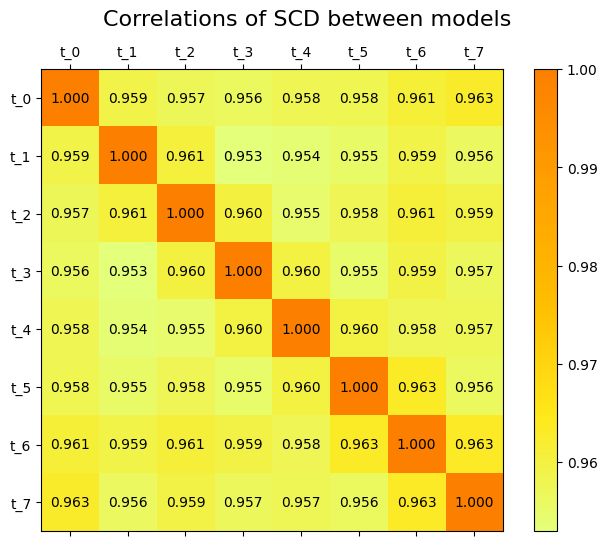

In [16]:
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111)
cax = ax.matshow(SCD_corr_summary, cmap="Wistia", interpolation='nearest')
fig.colorbar(cax)

names = [f"t_{i}" for i in range(num_models)]

xaxis = np.arange(len(names))
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(names)
ax.set_yticklabels(names)

for (x, y), value in np.ndenumerate(SCD_corr_summary):
    plt.text(x, y, f"{value:.3f}", va="center", ha="center")

fig.suptitle("Correlations of SCD between models", fontsize=16)

fig.show()

## Correlations between targets for model 0

Text(0.5, 0.98, 'Correlations of SCD between targets')

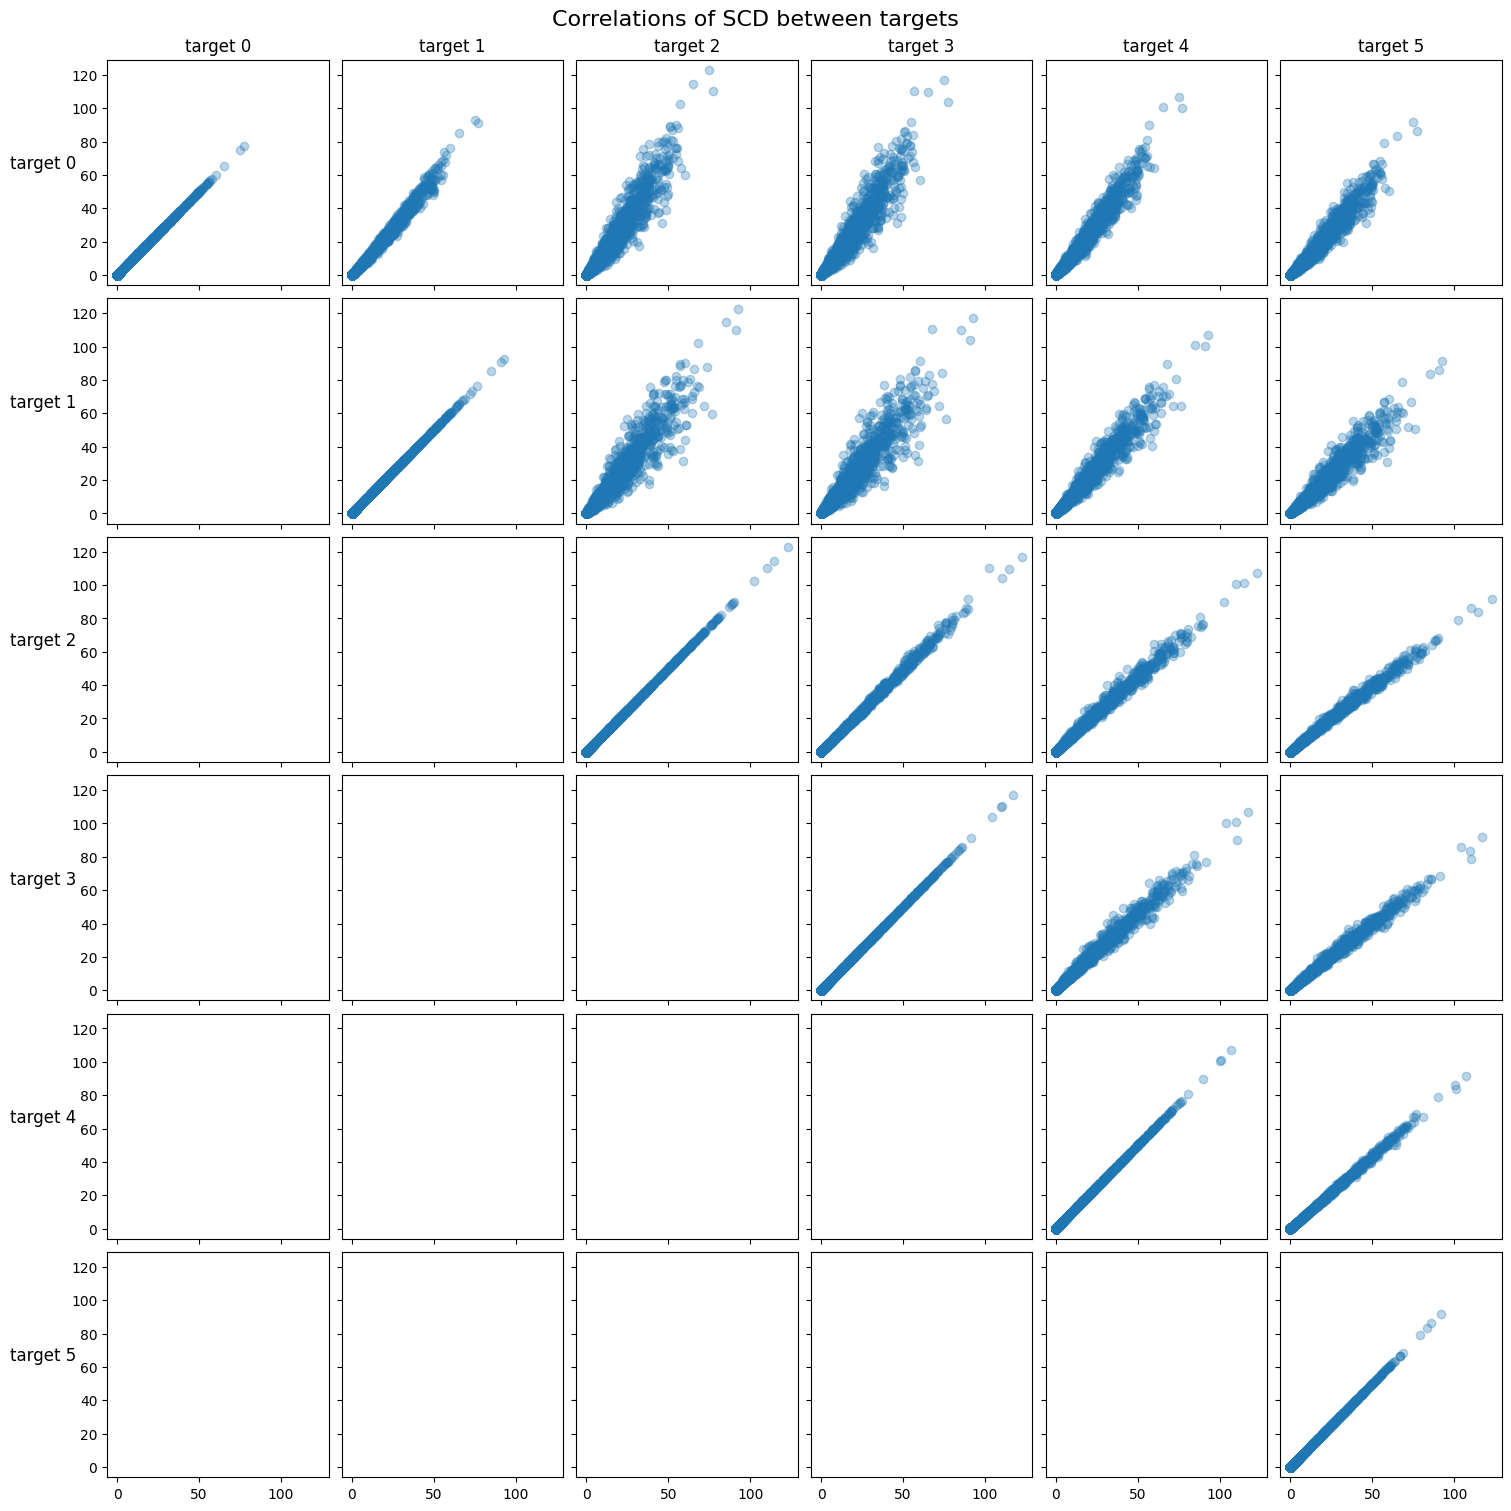

In [17]:
num_targets = 6
model_index = 0
stat = "SCD"
SCD_corr_summary = np.zeros((num_targets, num_targets))

fig, axs = plt.subplots(num_targets, num_targets, figsize=(15, 15), sharex=True, sharey=True, layout="constrained")

for target_index_x in range(num_targets):
    for target_index_y in range(num_targets):
        if (target_index_y >= target_index_x):
            
            stat_x = np.array(df_m0[f"{stat}_h1_m{model_index}_t{target_index_x}"])
            stat_y = np.array(df_m0[f"{stat}_h1_m{model_index}_t{target_index_y}"])
            
            axs[target_index_x, target_index_y].scatter(x=stat_x, y=stat_y, alpha=0.3)
            
            SCD_corr_summary[target_index_x, target_index_y] = SCD_corr_summary[target_index_y, target_index_x] = stats.pearsonr(stat_x, stat_y).statistic
            
names = [f"target {i}" for i in range(num_targets)]

for ax, col in zip(axs[0], names):
    ax.set_title(col, size=12)

for ax, row in zip(
    axs[:, 0],
    names,
):
    ax.set_ylabel(row, rotation=0, fontsize=12, labelpad=20)
    
fig.suptitle("Correlations of SCD between targets", fontsize=16)

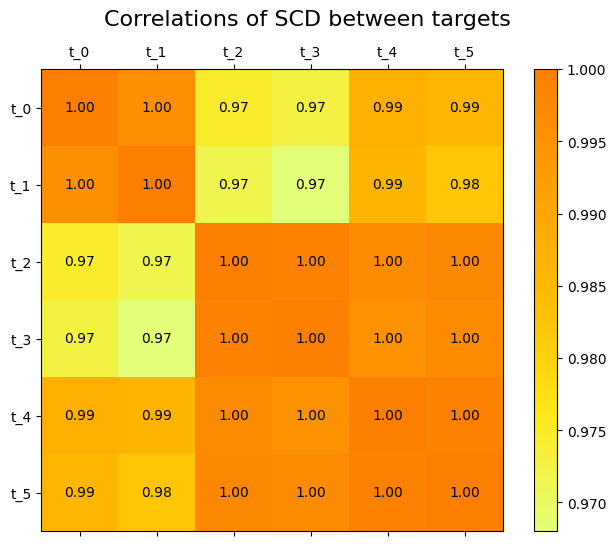

In [18]:
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111)
cax = ax.matshow(SCD_corr_summary, cmap="Wistia", interpolation='nearest')
fig.colorbar(cax)

names = [f"t_{i}" for i in range(num_targets)]

xaxis = np.arange(len(names))
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(names)
ax.set_yticklabels(names)

for (x, y), value in np.ndenumerate(SCD_corr_summary):
    plt.text(x, y, f"{value:.2f}", va="center", ha="center")

fig.suptitle("Correlations of SCD between targets", fontsize=16)

fig.show()

## Violin plot for targets (model 0)

In [19]:
def df_by_targets(input_df, stat, num_targets=6, head_index=1, model_index=0):
    """
    Extracts data from the specified columns in the input DataFrame to create a new DataFrame
    with 'target' indices and corresponding values for the given statistical measure.

    Parameters:
    - input_df (pd.DataFrame): The input DataFrame containing the data.
    - stat (str): The base name of the statistical measure columns.
    - num_targets (int, optional): The number of target indices. Default is 6.
    - head_index (int, optional): The head index value. Default is 1.
    - model_index (int, optional): The model index value. Default is 0.

    Returns:
    - pd.DataFrame: A new DataFrame with 'target' indices and corresponding values for the given statistical measure.
    """
    target_indices = []
    stat_score = []

    for target_index in range(num_targets):
        column_name = f"{stat}_h{head_index}_m{model_index}_t{target_index}"
        target_indices.extend([target_index] * len(input_df[column_name]))
        stat_score.extend(list(input_df[column_name]))

    output_df = pd.DataFrame({"target": target_indices, stat: stat_score})
    return output_df


In [20]:
target_df = df_by_targets(df_m0, "SCD")

<Axes: ylabel='SCD'>

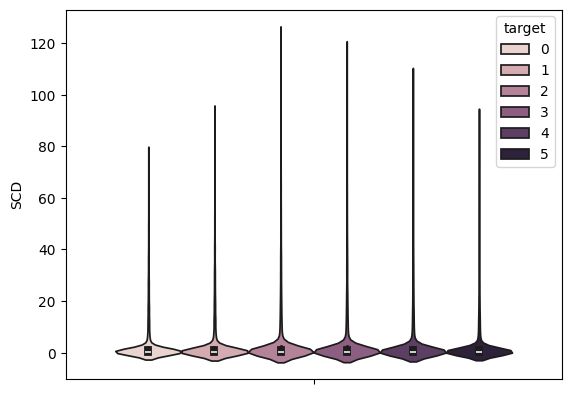

In [21]:
sn.violinplot(data=target_df, y="SCD", hue="target")